## Analysis over party's political score intervals: distribution and trending of words
In this part of the notebook we:
- Plot the distributions of the political scores per quote of Republicans vs Democrats
- Divide the distribution in 4 intervals and for each of those, grab the most common word of the quotes, in order to analyse our model prediction against to the political inclination.
- Plot 

In [1]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd
from helpers import *
from collections import Counter
import nltk
import texthero as hp
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

In [2]:
#read from dataset with predicted values for quotation
path = QUOTES_LABELED_CLEANED_PREDICTED
data = pd.read_json(path, lines=True, compression='bz2')

data.nosync/processed/quotes_labeled_cleaned_predicted.json.bz2


In [ ]:
data

,quoteID,quotation,speaker,date,numOccurrences,id,party_label,US_congress_bio_ID,quotation_clean,prob_dem
0,2015-08-31-000271,... a great day for veterans here in Littleton...,jeanne shaheen,2015-08-31 02:10:00,2,Q270316,D,S001181,great day veteran littleton across north count...,0.490675
1,2015-02-03-074650,The safety and security of our nation is at ri...,jeanne shaheen,2015-02-03 20:02:24,2,Q270316,D,S001181,safety security nation risk hold funding homel...,0.485331
2,2015-05-10-027625,It's been my experience that the faith communi...,jeanne shaheen,2015-05-10 22:48:46,1,Q270316,D,S001181,experience faith community willing partner gov...,0.622086
3,2015-09-01-113454,we need to bring the parents in so they can se...,jeanne shaheen,2015-09-01 02:12:00,2,Q270316,D,S001181,need bring parent see manufacturing worked sho...,0.613653
4,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",bernie sanders,2015-10-25 14:12:35,1,Q359442,D,S000033,ever gold standard trade agreement sander said...,0.935853
...,...,...,...,...,...,...,...,...,...,...
6396366,2020-02-10-100845,We're just worried about making sure we keep t...,sherrie sprenger,2020-02-10 00:00:00,1,Q7495360,R,None,worried making sure keep balance expression ri...,0.430030
6396367,2020-03-16-079753,We've all embraced strict proper hygiene proce...,robert abrams,2020-03-16 12:00:00,2,Q2156314,D,None,embraced strict proper hygiene procedure heard...,0.667447
6396368,2020-01-13-091997,What's important is that we keep moving forward.,laurie jinkins,2020-01-13 19:51:15,1,Q6501617,D,None,important keep moving forward,0.621014
6396369,2020-02-20-093793,"When they want a bill, they bring the bill to ...",j.t. wilcox,2020-02-20 22:12:45,1,Q6104393,R,None,want bill bring bill floor,0.342518


Lets anaylse some intervals of the probabilities score to see its most common words.
We could then for example relate words used to the strength of a politican inclination (how our model quantifies it).
The intervals used are:
- [0,0.25] and [0.25,0.5] for the republicans
- [0.5,0.75] and [0.75,1] for the democrats


In [3]:
#split dataset in republicans and democrats
rep = data[data.party_label == 'R']
dem = data[data.party_label == 'D']

This graph represent the distribution of the political score for each party (0-0.5 for the republicans, 0.5-1 for the democrats)

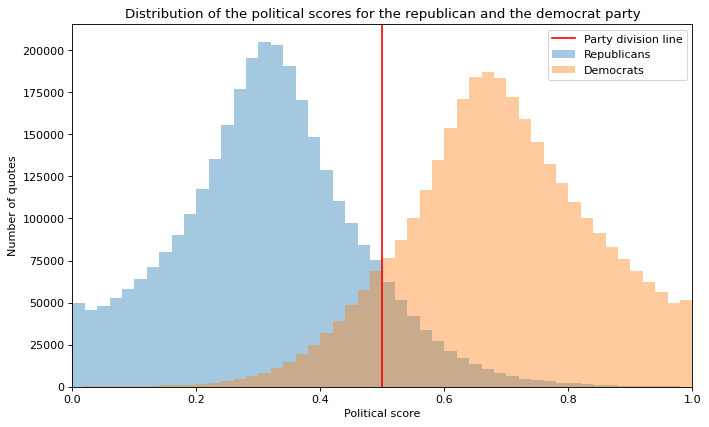

In [83]:
#plot the distributions

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6), dpi=80)
sns.distplot(rep['prob_dem'],  kde=False, label='Republicans')
sns.distplot(dem['prob_dem'],  kde=False,label='Democrats')
plt.axvline(0.5, 0,1,color='r')
plt.xlim(0, 1)
plt.legend(labels=['Party division line','Republicans','Democrats'])
plt.title('Distribution of the political scores for the republican and the democrat party')
plt.xlabel('Political score')
plt.ylabel('Number of quotes')
plt.savefig('img_distribution.png')

In [5]:
#divide in section (0, 0.25,0.75,1) and create 4 intervals
rep_first_interval = rep[(rep['prob_dem'] >=0) & (rep['prob_dem'] <=0.25)]
rep_second_interval= rep[(rep['prob_dem'] >0.25) & (rep['prob_dem'] <=0.5)]

dem_first_interval = dem[(dem['prob_dem'] >=0.5) & (dem['prob_dem'] <=0.75)]
dem_second_interval = dem[(dem['prob_dem'] >0.75) & (dem['prob_dem'] <=1)]

In [6]:
#function removing verbs from sentence
def remove_verbs_from_sentence(sentence):
    tokens = nltk.word_tokenize(sentence)
    #tags words, for example if the word is a verb in it's base form then it tags it with 'VB'
    #tagged becomes a list of tuples with (verb,tag) as format
    tagged = nltk.pos_tag(tokens)
    #filter all verbs from list
    tagged =list(filter(lambda x: x[1] not in  ['VB','VBD','VBG','VBN','VBP','VBZ','MD'],tagged))
    #remove tags from words
    words = list(map(lambda x: x[0], tagged))
    #join the words to have a sentence once againg
    sentence = ' '.join(words)
    return sentence


#function performing cleaning over words
def clean(series):
    series = hp.fillna(series)
    series = hp.lowercase(series)
    series = hp.remove_digits(series)
    series = hp.remove_punctuation(series)
    series = hp.remove_diacritics(series)
    series = hp.remove_stopwords(series)
    series = hp.remove_whitespace(series)
    
    return series
    
#function for getting the intervals top words
def get_interval_top_words(interval_df):
    #create list of words for all the quotes of an interval
    interval_word_list = interval_df['quotation'].apply(lambda x: x.split(' ')).tolist()
    interval_word_list = [item for sublist in interval_word_list for item in sublist]
    #clean the words so we only have important words
    interval_word_list  = clean(pd.Series(interval_word_list))
    
    # count the words
    words_to_count = (word for word in interval_word_list)
    c = Counter(words_to_count)
    return c
    

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/giomonopoli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/giomonopoli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [7]:
#republican intervals with top words
c_rep_first = get_interval_top_words(rep_first_interval)
c_rep_second = get_interval_top_words(rep_second_interval)

In [8]:
#democrat intervals with top words
c_dem_first = get_interval_top_words(dem_first_interval)
c_dem_second = get_interval_top_words(dem_second_interval)

In [65]:
#create tuple with words and count
arr_all_intervals = [c_rep_first,c_rep_second,c_dem_first,c_dem_second]
all_info_intervals = []
for ls in arr_all_intervals:
    arr = []
    for i in ls.most_common(20):
        res = ''
        try:   
            res = remove_verbs_from_sentence(i[0])
            if res:
                arr.append((res,i[1]))
        except:
            None
    all_info_intervals.append(arr)
        
print(all_info_intervals)

[[('president', 113151), ('people', 103229), ('think', 98754), ('state', 63621), ('one', 58851), ('trump', 57108), ('like', 52354), ('us', 51164), ('want', 50470), ('time', 49217), ('states', 42046), ('government', 40438), ('american', 39926), ('need', 39635)], [('people', 171492), ('think', 137349), ('one', 92985), ('state', 87063), ('like', 84438), ('want', 83488), ('time', 80209), ('us', 79171), ('need', 77761), ('really', 62916), ('work', 62454), ('way', 60109), ('good', 58058)], [('people', 176036), ('think', 127215), ('one', 90747), ('us', 84180), ('want', 81131), ('like', 80476), ('need', 79653), ('state', 78443), ('time', 78172), ('really', 64547), ('work', 63106), ('way', 59549), ('president', 58475), ('right', 56298)], [('people', 161226), ('new', 88031), ('city', 73420), ('need', 65604), ('one', 64762), ('us', 64469), ('country', 61901), ('president', 60767), ('state', 59082), ('think', 56628), ('health', 53811), ('time', 52369), ('community', 52263), ('like', 52073), ('work

In [66]:
#doing the sum and dividing so we have proportion and not absolute values
for ls in all_info_intervals:
    sum=0
    for value in ls:
        sum+=value[1]
        
    for i in range(len(ls)):
        ls[i] = (ls[i][0],ls[i][1]/sum)
    

In [74]:
#creating two arrays: with unique words per interval, with shared words between intervals

#we drop these words manually since we we want to have an array with unique words per interval (for plotting purposes)
drop_words = ['people','think','state','one','like','us','want','time','need','really','work','way']
arr = [[],[],[],[]]
#append shared words to another list (that we plot later)
for i in range(len(all_info_intervals)):
    for j in range(len(all_info_intervals[i])):
        tuple_to_remove = all_info_intervals[i][j]
        
        if tuple_to_remove[0] in drop_words:
            arr[i].append(tuple_to_remove)

#drop shared words from the all_info_intervals list so the unique words remain
for interval in all_info_intervals:
    for word in interval:
        if word[0] in drop_words:
            interval.remove(word)

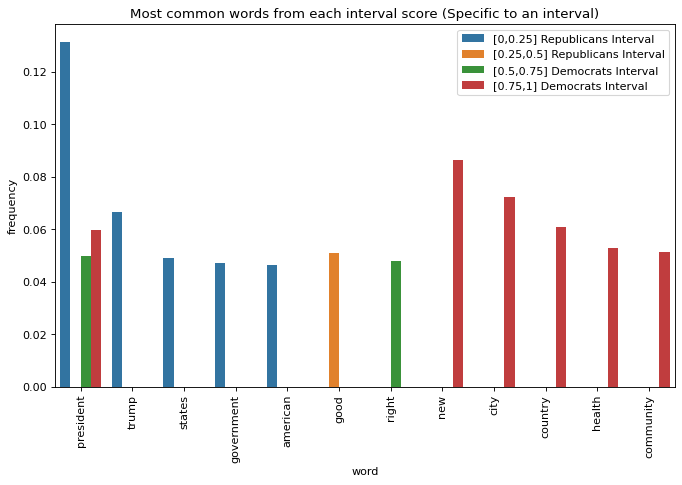

In [80]:
#function assembling dfs together so to have the following columns: word,frequency and interval
def make_df_word_freq(datas,interval_names):
    result = []
    for data,interval_name in zip(datas,interval_names):
        dataframe = pd.DataFrame(data , columns= ['word','frequency'])
        dataframe['interval'] = interval_name
        result.append(dataframe)
    return pd.concat(result)


#graph with unique words of each interval

data = make_df_word_freq(all_info_intervals,['[0,0.25] Republicans Interval','[0.25,0.5] Republicans Interval','[0.5,0.75] Democrats Interval','[0.75,1] Democrats Interval'])
plt.figure(figsize=(10, 6), dpi=80)
sns.barplot(data = data, x = 'word', y = 'frequency', hue='interval')
plt.xticks(rotation=90);
plt.title('Most common words from each interval score (Specific to an interval)')
plt.legend(loc='upper right');
plt.savefig('img_1(unique).png')

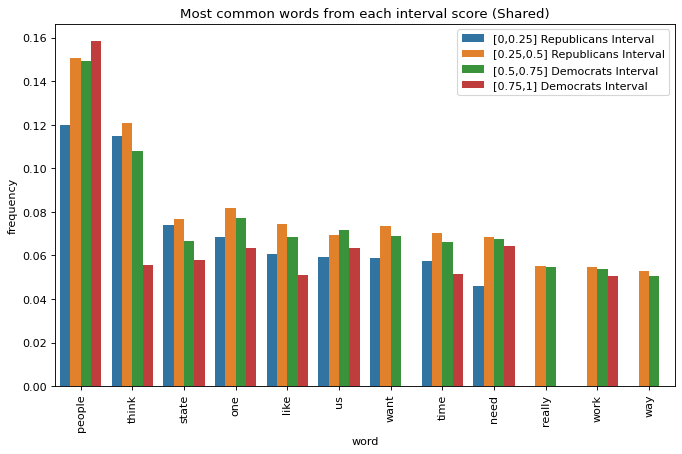

In [79]:
#the other graph with shared words between intervals

data = make_df_word_freq(arr,['[0,0.25] Republicans Interval','[0.25,0.5] Republicans Interval','[0.5,0.75] Democrats Interval','[0.75,1] Democrats Interval'])
plt.figure(figsize=(10, 6), dpi=80)
sns.barplot(data = data, x = 'word', y = 'frequency', hue='interval')
plt.xticks(rotation=90);
plt.title('Most common words from each interval score (Shared)')
plt.legend(loc='upper right')
plt.savefig('img_1(shared).png')

Now that we have a nice idea of some political ideas we continue on with our analysis and explorations in the [next notebook](part3_4-time_series_analysis.ipynb).